In [1]:

import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.tensorboard import SummaryWriter

from data_loader import prepare_cifar_dataloader,\
    CIFAR_CLASS_LABELS
from utils import plot_misclassified_images
from explainer import grad_cam
from metrics import get_metrics
import model


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
    device='mps:0'
    epochs=20
    batch_size=512
    n_misclassif=20
    n_grad_cam=20
    writer=SummaryWriter('GradCam')

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,728
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]          36,864
       BatchNorm2d-4           [-1, 64, 28, 28]             128
            Conv2d-5           [-1, 64, 28, 28]          36,864
       BatchNorm2d-6           [-1, 64, 28, 28]             128
        BasicBlock-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Conv2d-10           [-1, 64, 28, 28]          36,864
      BatchNorm2d-11           [-1, 64, 28, 28]             128
       BasicBlock-12           [-1, 64, 28, 28]               0
           Conv2d-13       

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.48E+00


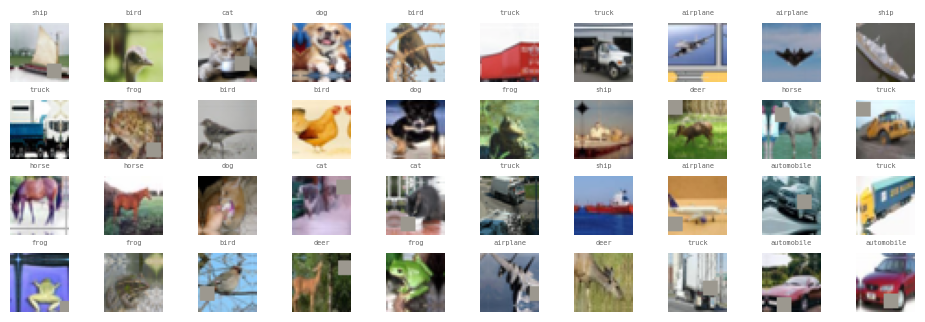

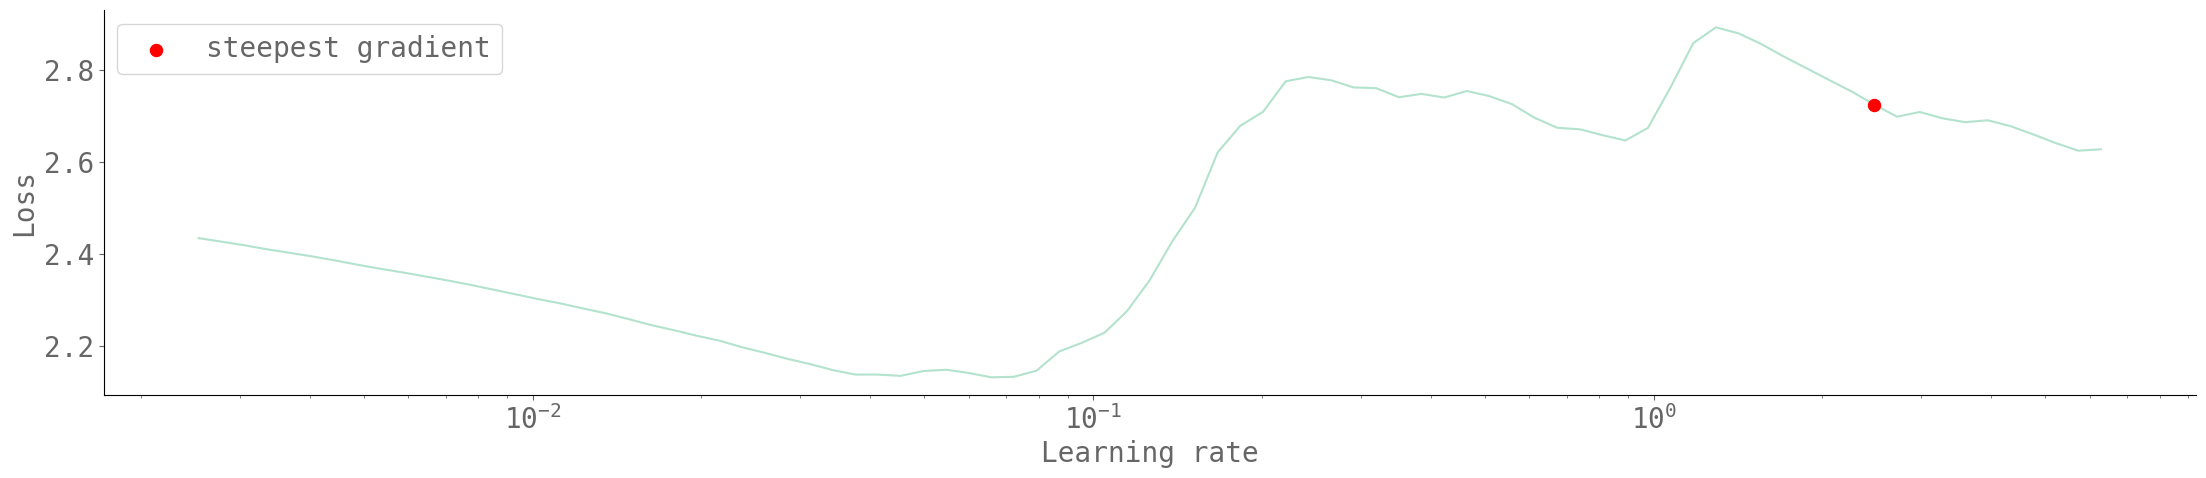

EPOCH: 0


Loss=1.8482 Batch_id=97 LR=0.51623 Accuracy=25.85: 100%|██████████| 98/98 [01:09<00:00,  1.42it/s]
100%|██████████| 20/20 [00:03<00:00,  5.56it/s]


Test set: Average loss: 0.0036, Accuracy: 3326/10000 (33.26%)

EPOCH: 1


Loss=1.4735 Batch_id=97 LR=1.00770 Accuracy=39.58: 100%|██████████| 98/98 [01:09<00:00,  1.42it/s]
100%|██████████| 20/20 [00:03<00:00,  5.66it/s]


Test set: Average loss: 0.0033, Accuracy: 4185/10000 (41.85%)

EPOCH: 2


Loss=1.3003 Batch_id=85 LR=1.43898 Accuracy=48.46:  88%|████████▊ | 86/98 [01:01<00:08,  1.39it/s]

In [3]:
train_loader, test_loader = prepare_cifar_dataloader(
    batch_size=batch_size
)
utils.plot_img_batch(
    train_loader, CIFAR_CLASS_LABELS,
    ncols=10, nrows=4)

network = model.ResNet18()
print(model.summary_printer(network))
network.to(device)


optimizer = optim.SGD(network.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()
suggested_lr = model.lr_finder(
    network, optimizer, criterion, device, train_loader,
    writer)

scheduler = OneCycleLR(
    optimizer, max_lr=suggested_lr,
    steps_per_epoch=len(train_loader),
    epochs=epochs, 
    pct_start=5/epochs, 
    three_phase=False,
    div_factor=100,
    final_div_factor=100,
    anneal_strategy='linear',
)

for epoch in range(epochs):
    print("EPOCH:", epoch)
    model.train(network, device, 
        train_loader, optimizer, scheduler, writer)
    test_acc = model.test(network, device, test_loader, writer)

model.plot_loss_n_acc(writer)

## plot_misclassified images
labels_df = model.get_pred_n_actuals(network, test_loader, device)
plot_misclassified_images(labels_df, test_loader.dataset, 
        CIFAR_CLASS_LABELS, n_samples=n_misclassif,
        nrows=2, ncols=10, figsize=(25,6),
        title='misclassified images (Pred | Target)', )

get_metrics(labels_df, CIFAR_CLASS_LABELS)


## Grad cam visualization
target_layers = [network.layer3[-1]]
inputs, target = next(iter(train_loader))
input_tensor = inputs[:n_grad_cam].to(device)
true_class = target[:n_grad_cam].to(device)
cam_output = grad_cam(network, target_layers,
    input_tensor, None)